In [75]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import networkx as nx
import numpy as np
import random
import time
import math

In [76]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [77]:
plt_options = {
  "node_size": 350,
  "node_color": "white",
  "edgecolors": "black",
  "with_labels": True,
  "font_size": 8
}

agent_path_draw_delay = 1

In [78]:
def load_dataset():
  (trainX, trainY), (testX, testY) = keras.datasets.mnist.load_data()

  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  trainY = to_categorical(trainY)
  testY = to_categorical(testY)

  return trainX, trainY, testX, testY

In [79]:
def prep_pixels(train, test):
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')

	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0

	return train_norm, test_norm

In [80]:
def define_model():
  model = keras.Sequential()
  model.add(Flatten(input_shape=(28, 28)))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [81]:
def evaluate_model(trainX, trainY, testX, testY):
  model = define_model()
  history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY))

  return model, history

In [82]:
def print_history_metrics(history):
  _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

  plots_data = [
      [
        'loss',
        'val_loss',
        {'title': 'Loss', 'x_label': 'Epochs', 'y_label': 'Loss'}
      ],
      [
        'accuracy',
        'val_accuracy',
        {'title': 'Accuracy', 'x_label': 'Epochs', 'y_label': 'Accuracy'}
      ]
  ]

  for i in range(len(plots_data)):
    train_key, value_key, meta = plots_data[i]

    axes[i].set_title(meta['title'])
    axes[i].set_xlabel(meta['x_label'])
    axes[i].set_ylabel(meta['y_label'])
    axes[i].plot(history.history[train_key], color='blue', label='Train')
    axes[i].plot(history.history[value_key], color='orange', label='Test')
    axes[i].legend()

  plt.tight_layout()
  plt.show()

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3079 - accuracy: 0.9121 - val_loss: 0.1778 - val_accuracy: 0.9480
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1454 - accuracy: 0.9588 - val_loss: 0.1219 - val_accuracy: 0.9630
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1050 - accuracy: 0.9697 - val_loss: 0.1033 - val_accuracy: 0.9690
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0833 - accuracy: 0.9754 - val_loss: 0.0900 - val_accuracy: 0.9730
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0686 - accuracy: 0.9797 - val_loss: 0.0810 - val_accuracy: 0.9761
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0579 - accuracy: 0.9836 - val_loss: 0.0775 - val_accuracy: 0.9761
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0497 - accuracy: 0.9855 - val_loss: 0.0824 - val_accuracy:

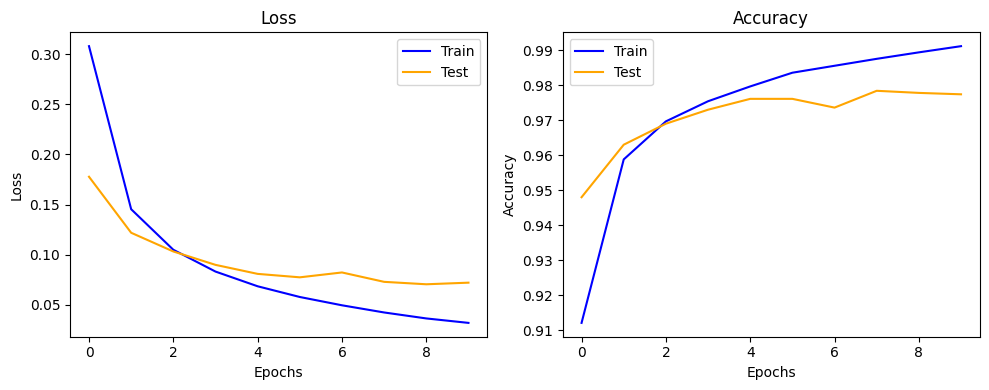

In [83]:
trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
model, history = evaluate_model(trainX, trainY, testX, testY)
print_history_metrics(history)

In [84]:
def setup_road(n_edges_to_remove, m = 5, n = 5):
  G = nx.grid_2d_graph(m, n)

  available_edges = list(G.edges)

  max_edges_to_remove = len(list(G.edges)) - len(list(G.nodes)) + 1

  i = 0

  while i < n_edges_to_remove and i < max_edges_to_remove:
    selected_edge = random.choice(available_edges)
    G.remove_edge(*selected_edge)

    if not nx.is_connected(G):
      G.add_edge(*selected_edge)
    else:
      i += 1

    available_edges.remove(selected_edge)

  return G

In [85]:
def get_speed_images(n=20):
  images = []

  for i in range(len(testY)):
    label_value = np.argmax(testY[i])

    if label_value in (0, 1):
      continue;

    if len(images) < n:
      image = testX[i]
      image = np.expand_dims(image, axis=-1)
      image = np.expand_dims(image, axis=0)

      images.append((label_value, image))
    else:
      break;

  return images

In [146]:
def draw_agent_path(path, road, current_crossroads, visited_crossroads):
    path_edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    speed_sign_value = nx.get_edge_attributes(road, "speed_sign_value")
    edge_labels = {edge: speed_sign_value[edge] for edge in road.edges()}

    pos = {(x,y):(y,-x) for x,y in road.nodes()}

    path_node_color = ['red' if node == current_crossroads else 'yellowgreen' for node in path]
    visited_crossroads_node_color = ['gray' if node in visited_crossroads else 'white' for node in road.nodes]

    plt.figure(figsize=(5,5))
    nx.draw(road, pos=pos, **{ **plt_options, 'node_color': visited_crossroads_node_color })
    nx.draw_networkx_nodes(road, nodelist=path, pos=pos, node_color=path_node_color)
    nx.draw_networkx_edges(road, edgelist=path_edges, pos=pos, edge_color='yellowgreen')
    nx.draw_networkx_edge_labels(road, edge_labels=edge_labels, pos=pos)
    plt.show()

In [131]:
def place_speed_signs(road):
  edges = list(road.edges())
  images = get_speed_images()

  for edge in edges:
      image = random.choice(images)

      road[edge[0]][edge[1]]['speed_sign_image'] = image[1]
      road[edge[0]][edge[1]]['speed_sign_value'] = image[0] * 10

In [88]:
class KnowledgeBase:
  def __init__(self):
    self.available_paths = {}
    self.visited_crossroads = []

  def _get_unvisited(self, crossroads_list):
    unvisited_crossroads = []

    for crossroads in crossroads_list:
      if crossroads not in self.visited_crossroads:
        unvisited_crossroads.append(crossroads)

    return unvisited_crossroads

  def _calculate_distance(self, crossroads_a, crossroads_b):
    destY, destX = crossroads_b
    depY, depX = crossroads_a

    return math.sqrt((destX - depX)**2 + (destY - depY)**2)

  def update(self, crossroads, neighbords):
    self.visited_crossroads.append(crossroads)
    self.available_paths = {**self.available_paths, crossroads: neighbords}


  def suggent_next_move(self, current_crossroads, dest):
    available_crossroads = self.available_paths[current_crossroads]

    unvisited_crossroads = self._get_unvisited(available_crossroads)

    min_distance = float('inf')

    next_crossroads = None

    for crossroads in unvisited_crossroads:
      unvisited_neighbors = self._get_unvisited(available_crossroads[crossroads])

      if crossroads == dest:
        return crossroads

      if not unvisited_neighbors:
        continue

      distances = map(lambda item: self._calculate_distance(item, dest), unvisited_neighbors)

      local_min_distance = min(list(distances))

      if local_min_distance < min_distance:
        min_distance = local_min_distance
        next_crossroads = crossroads

    return next_crossroads

In [147]:
class Agent:
  def __init__(self, road: nx.Graph, knowledge_base: KnowledgeBase, camera):
    self.road = road
    self.knowledge_base = knowledge_base
    self.current_crossroads = None
    self.moves_count = 0
    self.camera = camera
    self.total_speed = 0

  def tell(self, current_crossroads):
    available_paths = {}

    for neighbor in self.road.neighbors(current_crossroads):
      available_paths[neighbor] = list(self.road.neighbors(neighbor))

    self.knowledge_base.update(current_crossroads, available_paths)

  def ask(self, dest):
    return self.knowledge_base.suggent_next_move(self.current_crossroads, dest)

  def act(self, next_crossroads, stack):
    if next_crossroads:
      scanned_speed = self.scan_speed(self.current_crossroads, next_crossroads)
      self.total_speed += scanned_speed

      print(f"#{self.moves_count} Move: {next_crossroads}")
      print(f"🚦 Scanned speed on {self.current_crossroads}-{next_crossroads}: {scanned_speed}km/h")
      print(f"🟢 Avg speed: {round(self.total_speed / self.moves_count)}km/h")
      stack.append(next_crossroads)
    else:
      stack.pop()

      if stack:
        print(f"#{self.moves_count} 🔴 Dead end! Move back to {stack[-1]}")

    if stack:
      self.current_crossroads = stack[-1]

  def scan_speed(self, dep, dest):
    road_part = self.road.get_edge_data(dep, dest)
    predicted_speed = self.camera.predict(road_part['speed_sign_image'], verbose=0).argmax()

    return predicted_speed * 10

  def drive(self, dep, dest):
    stack = [dep]

    self.current_crossroads = dep

    self.moves_count = 0

    while self.current_crossroads != dest and stack:
      self.moves_count += 1

      self.tell(self.current_crossroads)
      next_crossroads = self.ask(dest)
      self.act(next_crossroads, stack)

      draw_agent_path(stack, self.road, self.current_crossroads, self.knowledge_base.visited_crossroads)
      time.sleep(agent_path_draw_delay)
      clear_output(wait=True)

    if stack:
      print(f"🟢 Stop! Path is found: {stack}")
    else:
      print("❌ Path wasn't found!")

    draw_agent_path(stack, self.road, self.current_crossroads, self.knowledge_base.visited_crossroads)

    return stack

🟢 Stop! Path is found: [(0, 1), (1, 1), (1, 2), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)]


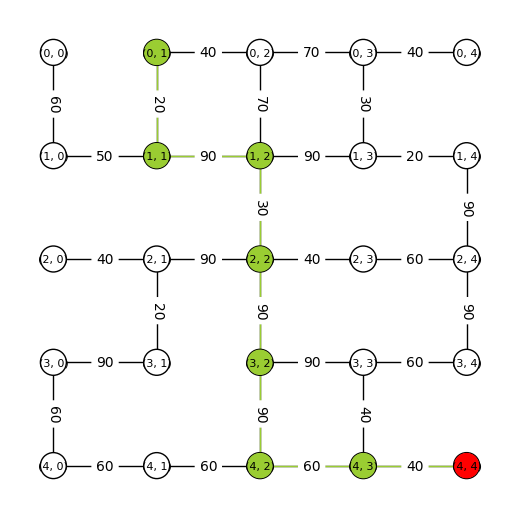

In [152]:
road = setup_road(n_edges_to_remove=10)
place_speed_signs(road)
knowledge_base = KnowledgeBase()
agent = Agent(road, knowledge_base, model)

path = agent.drive((0, 1), (4, 4))

**Висновок**: виконавши дану лабораторну роботу, було удосконалено інтелектуального агента розробленого у лабораторній роботі #2, шляхом створення та використання власної бази знань. Завдяки цим змінам та новій інформації про середовище, агент отримав можливість зберігати дану інформацію до бази знань, що дозволило йому краще орієнтуватися в просторі та уникати помилок.